#  從資料庫擷取醫師標記的結果，並將資料的特徵彙整一起，下載圖片至指定資料夾。

In [18]:
import pandas
import numpy
import sklearn
import pymysql
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
import requests, pandas
from PIL import Image
from io import BytesIO
import tqdm
import os 

訪問醫師標記的總表，擷取時間 2021/09/22 以前的醫師標記資料，並將「痣」的部份提取出來，同一筆資料一位醫師只能標記一次，形成表格。

In [19]:
##  The client of database.
connection = pymysql.connect(
    host='dermai.clhzpxphx83l.ap-northeast-1.rds.amazonaws.com',
    user='admin',
    password='dermai_root_1234',
    database='moleUp',
    charset='utf8'
)
date = "'2021-09-22 00:00:00'"
query = "SELECT * FROM `results` where create_time < {};".format(date)
table = pandas.read_sql(query, connection)
table = table.loc[(table['dataset']=='MoleMe')|(table['dataset']=='MoleMe_OA')]
doctor = ['leon', 'christine', 'dave', 'eric', 'jack']
table = table.loc[[i in doctor for i in table['dr']]]
table = table.loc[table['prediction']!='']

過濾醫師針對某筆資料進行重複標記的情況

In [20]:
table['index'] = table['image_name'] + table['dr']
table = table.drop_duplicates(subset=['index'])
print(table.shape)
table.head()

(4369, 13)


,rowid,dataset,image,user_id,image_name,score,prediction,dr,dr_yoe,result,times,create_time,index
4,5,MoleMe_OA,48,U199c77fc82b06db1a0e682abf9ee2507,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...,0.6862580180168152,Lower,jack,1,higher,2021-06-11 00:57:57,2021-06-11 00:57:57,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...
5,6,MoleMe_OA,51,U199c77fc82b06db1a0e682abf9ee2507,U199c77fc82b06db1a0e682abf9ee2507-qexnechh-201...,0.7413929104804993,Lower,jack,1,higher,2021-06-11 00:58:00,2021-06-11 00:58:00,U199c77fc82b06db1a0e682abf9ee2507-qexnechh-201...
7,17,MoleMe_OA,24072,U175afc1f2d8c4edbbbcb7ce4d866200d,U175afc1f2d8c4edbbbcb7ce4d866200d-5s66phm1-202...,0.9317312836647034,Higher,jack,1,lower,2021-06-25 00:46:28,2021-06-25 00:46:28,U175afc1f2d8c4edbbbcb7ce4d866200d-5s66phm1-202...
9,19,MoleMe_OA,18164,U771c74f21c1456e4cebc55405bcb5f5b,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...,0.9598649144172668,Higher,jack,1,lower,2021-06-25 00:58:43,2021-06-25 00:58:43,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...
10,20,MoleMe_OA,18161,U2c0c1a77ebb9ffe0c9a616bae5d3148b,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...,0.8503648042678833,Higher,jack,1,lower,2021-06-25 00:58:45,2021-06-25 00:58:45,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...


每一位醫師標記的數量

In [21]:
table['month'] = [str(i).split(" ")[0][:-3] for i in table['create_time']]
print(date)
table.groupby(['month', "dr"]).count()

'2021-09-22 00:00:00'


rowid  dataset  image  user_id  image_name  score  \
month   dr                                                             
2021-06 jack          15       15     15       15          15     15   
2021-07 dave          38       38     38       38          38     38   
        jack          40       40     40       40          40     40   
        leon          37       37     37       37          37     37   
2021-08 dave          75       75     75       75          75     75   
        eric          25       25     25       25          25     25   
        leon        1269     1269   1269     1269        1269   1269   
2021-09 christine    389      389    389      389         389    389   
        dave          73       73     73       73          73     73   
        leon        2408     2408   2408     2408        2408   2408   

                   prediction  dr_yoe  result  times  create_time  index  
month   dr                                                                
2021-06 jack               15      15      15     15           15     15  
2021-07 dave               38      38      38     38           38     38  
        jack               40      40      40     40           40     40  
        leon               37      37      37     37           37     37  
2021-08 dave               75      75      75     75           75     75  
        eric               25      25      25     25           25     25  
        leon             1269    1269    1269   1269         1269   1269  
2021-09 christine         389     389     389    389          389    389  
        dave               73      73      73     73           73     73  
        leon             2408    2408    2408   2408         2408   2408

多位醫師標記進行投票

In [22]:
def vote(table):
    group = {
        "dataset":[],
        'image':[],
        "user_id":[],
        "image_name":[],
        "score":[],
        "prediction":[],
        "vote":[]
    }
    for i in table['image_name'].unique().tolist():

        item = table.loc[table['image_name']==i]

        ##  處理標記以外的資訊
        group['dataset'] += [item['dataset'].values[0]]
        group['image'] += [item['image'].values[0]]
        group['user_id'] += [item['user_id'].values[0]]
        group['image_name'] += [item['image_name'].values[0]]
        group['score'] += [item['score'].values[0]]
        group['prediction'] += [item['prediction'].values[0]]
        pass

        ##  該筆資料有幾位醫師標記
        number = len(item['dr'].unique())

        ##  一位醫師標記的處理方式
        if(number==1):

            group['vote'] += [item['result'].item()]
            continue

        ##  兩位醫師標記的處理方式
        if(number==2):

            different = len(item['result'].unique())
            if(different==2):

                group['vote'] += ['unknown']
                pass

            else:
            
                group['vote'] += [item['result'].max()]
                pass
            
            continue
        
        ##  三位醫師標記的處理方式
        if(number==3):

            different = len(item['result'].unique())
            if(different==3):

                group['vote'] += ['Unknown']
                pass
            
            if(different==2 or different==1):

                group['vote'] += [item['result'].max()]
                pass
            
            continue
        
        ##  四位醫師標記的處理方式
        if(number==4):

            print("to do list")
            break
        
        pass

    output = pandas.DataFrame(group)
    return(output)
table = vote(table=table)
print(table.shape)
table.head()

(4019, 7)


,dataset,image,user_id,image_name,score,prediction,vote
0,MoleMe_OA,48,U199c77fc82b06db1a0e682abf9ee2507,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...,0.6862580180168152,Lower,higher
1,MoleMe_OA,51,U199c77fc82b06db1a0e682abf9ee2507,U199c77fc82b06db1a0e682abf9ee2507-qexnechh-201...,0.7413929104804993,Lower,higher
2,MoleMe_OA,24072,U175afc1f2d8c4edbbbcb7ce4d866200d,U175afc1f2d8c4edbbbcb7ce4d866200d-5s66phm1-202...,0.9317312836647034,Higher,lower
3,MoleMe_OA,18164,U771c74f21c1456e4cebc55405bcb5f5b,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...,0.9598649144172668,Higher,lower
4,MoleMe_OA,18161,U2c0c1a77ebb9ffe0c9a616bae5d3148b,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...,0.8503648042678833,Higher,lower


In [23]:
table['prediction'] = table['prediction'].str.lower()
table['vote'] = table['vote'].str.lower()

In [24]:
table = table.loc[(table['vote']=='lower')|(table['vote']=='higher')]
table_label = table.copy()
table_label['mole_size'] = None
table_label['change'] = None
table_label['gender'] = None
table_label['age'] = None
table_label['period'] = None

print(table_label.shape)
table_label.head()

(3308, 12)


,dataset,image,user_id,image_name,score,prediction,vote,mole_size,change,gender,age,period
0,MoleMe_OA,48,U199c77fc82b06db1a0e682abf9ee2507,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...,0.6862580180168152,lower,higher,None,None,None,None,None
1,MoleMe_OA,51,U199c77fc82b06db1a0e682abf9ee2507,U199c77fc82b06db1a0e682abf9ee2507-qexnechh-201...,0.7413929104804993,lower,higher,None,None,None,None,None
2,MoleMe_OA,24072,U175afc1f2d8c4edbbbcb7ce4d866200d,U175afc1f2d8c4edbbbcb7ce4d866200d-5s66phm1-202...,0.9317312836647034,higher,lower,None,None,None,None,None
3,MoleMe_OA,18164,U771c74f21c1456e4cebc55405bcb5f5b,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...,0.9598649144172668,higher,lower,None,None,None,None,None
4,MoleMe_OA,18161,U2c0c1a77ebb9ffe0c9a616bae5d3148b,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...,0.8503648042678833,higher,lower,None,None,None,None,None


根據標記資料回頭去資料庫撈取對應的特徵數據，找不到數據要進行回報。

In [25]:
connection = pymysql.connect(
    host='dermai.clhzpxphx83l.ap-northeast-1.rds.amazonaws.com',
    user='admin',
    password='dermai_root_1234',
    database='ai_tools'
)
query = "SELECT * FROM `moleme`;"
table = pandas.read_sql(query, connection)[['user_id', 'timestamp', 'image', 'image_crop', 'mole_size', "period", "change", "gender", "age"]]
table['mole_size'] = table['mole_size'].replace({"0":"有","1":"沒有"})
table['change'] = table['change'].replace({"0":"有","1":"沒有","2":"不確定"})
table['gender'] = table['gender'].replace({"0":"男性", "1":"女性","2":"不想回答"})
table['age'] = table['age'].replace({"0":"21歲以下","1":"21~40歲", "2":"41~65歲", "3":"65歲以上"})
table['period'] = table['period'].replace({"0":"一個月內",'1':"1個月~1年", "2":"一年以上","3":"不記得"})

In [26]:
skip = []
find = []
for index, item in table_label.iterrows():

    a = table.loc[table['image_crop']==item['image_name']]
    b = table.loc[table['image']==item['image_name']]
    if(a.shape[0]!=0):

        table_label.at[index, 'mole_size'] = a['mole_size'].values[0]
        table_label.at[index, 'change'] = a['change'].values[0]
        table_label.at[index, 'gender'] = a['gender'].values[0]
        table_label.at[index, 'age'] = a['age'].values[0]
        table_label.at[index, 'period'] = a['period'].values[0]
        find += [index]
        continue

    if(b.shape[0]!=0):

        table_label.at[index, 'mole_size'] = b['mole_size'].values[0]
        table_label.at[index, 'change'] = b['change'].values[0]
        table_label.at[index, 'gender'] = b['gender'].values[0]
        table_label.at[index, 'age'] = b['age'].values[0]
        table_label.at[index, 'period'] = b['period'].values[0]
        find += [index]
        continue

    print("{} : 在 'ai_tools' 表中找不到".format(item['image_name']))
    skip += [index]
    pass

U199c77fc82b06db1a0e682abf9ee2507-qexnechh-201912041224.jpg : 在 'ai_tools' 表中找不到
U175afc1f2d8c4edbbbcb7ce4d866200d-5s66phm1-202106210841.jpg : 在 'ai_tools' 表中找不到
U91697d3609acb05d3fb7b4d80cbd2fd1-liwsil2r-202102120729.jpg : 在 'ai_tools' 表中找不到
U418f575594159140c83a38c36d17005b-ewecitj9-202102091403.jpg : 在 'ai_tools' 表中找不到
U24e7c442227b90edca3d56e93a25e153-uudivg8b-201912030013.jpg : 在 'ai_tools' 表中找不到
U0b422be5647ba1727729746117f15173-zvkrjddr-201912031504.jpg : 在 'ai_tools' 表中找不到
Ufcdf6a4addd447b96906371ce6159c4c-k69bo7yf-201912031601.jpg : 在 'ai_tools' 表中找不到
Uff50decc59b99a00541aba16d0037983-f9i_cbz9-201912040328.jpg : 在 'ai_tools' 表中找不到
U68195c800af29063d854fb1aaeca7162-yegh7hz3-201912040618.jpg : 在 'ai_tools' 表中找不到
U0f95cc471e7c7b0e75e9fa81ea775f23-dssi37vf-201912041508.jpg : 在 'ai_tools' 表中找不到
U1deddd28e7f34cecf5b8b95d072fdd3f-t97yiuiv-201912041602.jpg : 在 'ai_tools' 表中找不到
Uefb7dbb3b900105f0b99fda1118030e8-95efm104-201912042332.jpg : 在 'ai_tools' 表中找不到
Ucaa6ca15ab272f73d194d6875d5

In [27]:
table_label = table_label.loc[find].copy()
print(table_label.shape)
table_label.head()

(3278, 12)


,dataset,image,user_id,image_name,score,prediction,vote,mole_size,change,gender,age,period
0,MoleMe_OA,48,U199c77fc82b06db1a0e682abf9ee2507,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...,0.6862580180168152,lower,higher,有,不確定,女性,21~40歲,一年以上
3,MoleMe_OA,18164,U771c74f21c1456e4cebc55405bcb5f5b,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...,0.9598649144172668,higher,lower,有,有,女性,41~65歲,一年以上
4,MoleMe_OA,18161,U2c0c1a77ebb9ffe0c9a616bae5d3148b,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...,0.8503648042678833,higher,lower,有,沒有,男性,21~40歲,一年以上
6,MoleMe_OA,18124,U91697d3609acb05d3fb7b4d80cbd2fd1,U91697d3609acb05d3fb7b4d80cbd2fd1-wq8tx2y6-202...,0.9538336396217346,higher,lower,沒有,不確定,女性,41~65歲,一年以上
7,MoleMe_OA,18121,U587ce984ad6f646ea09f75d90057a1af,U587ce984ad6f646ea09f75d90057a1af-tl6475in-202...,0.8612645268440247,higher,lower,有,沒有,男性,41~65歲,一年以上


下載圖片，發現 'image' 欄位有錯，有些圖片名稱結尾有 '_crop' ，有些沒有，不正常。

In [28]:
import re
table_label['image_default'] = None
table_label['image_crop'] = None
for index, item in table_label.iterrows():

    if('crop' in item['image_name']):

        crop = item['image_name']
        default = re.sub("_crop", "", item['image_name'])
        pass

    else:

        default = item['image_name']
        crop = re.sub(".jpg", "_crop.jpg", item['image_name'])
        pass

    table_label.at[index, 'image_default'] = default
    table_label.at[index, 'image_crop'] = crop
    pass

table_label.head()

,dataset,image,user_id,image_name,score,prediction,vote,mole_size,change,gender,age,period,image_default,image_crop
0,MoleMe_OA,48,U199c77fc82b06db1a0e682abf9ee2507,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...,0.6862580180168152,lower,higher,有,不確定,女性,21~40歲,一年以上,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...
3,MoleMe_OA,18164,U771c74f21c1456e4cebc55405bcb5f5b,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...,0.9598649144172668,higher,lower,有,有,女性,41~65歲,一年以上,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...
4,MoleMe_OA,18161,U2c0c1a77ebb9ffe0c9a616bae5d3148b,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...,0.8503648042678833,higher,lower,有,沒有,男性,21~40歲,一年以上,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...
6,MoleMe_OA,18124,U91697d3609acb05d3fb7b4d80cbd2fd1,U91697d3609acb05d3fb7b4d80cbd2fd1-wq8tx2y6-202...,0.9538336396217346,higher,lower,沒有,不確定,女性,41~65歲,一年以上,U91697d3609acb05d3fb7b4d80cbd2fd1-wq8tx2y6-202...,U91697d3609acb05d3fb7b4d80cbd2fd1-wq8tx2y6-202...
7,MoleMe_OA,18121,U587ce984ad6f646ea09f75d90057a1af,U587ce984ad6f646ea09f75d90057a1af-tl6475in-202...,0.8612645268440247,higher,lower,有,沒有,男性,41~65歲,一年以上,U587ce984ad6f646ea09f75d90057a1af-tl6475in-202...,U587ce984ad6f646ea09f75d90057a1af-tl6475in-202...


In [29]:
from multiprocessing import Process, Manager
def pull(table, thread, output):

    output["{} thread error term".format(thread)] = []
    folder = 'jpg/'
    url = ["https://reservation.dermai.com.tw/static/media/data/mole/", "https://oldmoleme.dermai.com.tw/static/data/"]
    selection = table.loc[table['thread']==thread].reset_index(drop=True).copy()
    total = len(selection)
    for _, item in tqdm.tqdm(selection.iterrows(), total=total):

        os.makedirs(os.path.join(folder, 'default', item['vote']), exist_ok=True)
        os.makedirs(os.path.join(folder, 'crop', item['vote']), exist_ok=True)

        try:
        
            source = requests.get(url[0]+item['image_default'], timeout=1)
            image = Image.open(BytesIO(source.content))
            image.save(os.path.join(folder, 'default', item['vote'], item['image_default']))
            # table_label.at[iteration, 'download_default'] = True
            pass
        
        except:
        
            try:            
        
                source = requests.get(url[1]+item['image_default'], timeout=1)
                image = Image.open(BytesIO(source.content))
                image.save(os.path.join(folder, 'default', item['vote'], item['image_default']))
                # table_label.at[iteration, 'download_default'] = True
                pass
        
            except:
                
                output["{} thread error term".format(thread)] += [item['image_default']]
                # print("Image_default {} download error".format(item['image_default']))
                # table_label.at[iteration, 'download_default'] = False
                pass
        
            pass

        try:
            
            source = requests.get(url[0]+item['image_crop'], timeout=1)
            image = Image.open(BytesIO(source.content))
            image.save(os.path.join(folder, 'crop', item['vote'], item['image_crop']))
            # table_label.at[iteration, 'download_crop'] = True
            pass
            
        except:

            try:

                source = requests.get(url[1]+item['image_crop'], timeout=1)
                image = Image.open(BytesIO(source.content))
                image.save(os.path.join(folder, 'crop', item['vote'], item['image_crop']))
                # table_label.at[iteration, 'download_crop'] = True
                pass

            except:

                # table_label.at[iteration, 'download_crop'] = False
                # print("Image_crop {} download error".format(item['image_crop']))
                output["{} thread error term".format(thread)] += [item['image_crop']]
                pass

            pass

        # print("The {} thread, {}/{}.".format(thread, index+1, total))
        pass

    return

用多線程的方法來下載圖片，增加效率。

In [30]:
task = {}
table_label['thread'] = [i%8+1 for i in range(len(table_label))]
error = Manager().dict()
for k in table_label['thread'].unique():

    task[str(k)] = Process(target=pull, args=[table_label, k, error])
    task[str(k)].start()
    pass

for _, t in task.items():

    t.join()
    pass

print("Finish download process.")

100%|██████████| 410/410 [11:18<00:00,  1.65s/it]


Finish download process.


下載失敗的圖片回報。

In [35]:
error.values()

[['U2f8d6a6f1a9c0cc8408f19ae41b4d3e8-20210525191302.jpg',
  'U2fd29069ba08d5465257f6c77e2f9124-ujkjjqsp-202001070841_crop.jpg',
  'Udd630ada1853a761d6e829b7a7310a07-9pytl9dk-202004010353_crop.jpg',
  'U4720f5c1333dd5822d21549d86ce77ad-kidmxbqg-202004070547_crop.jpg',
  'U228972cd267dc029fd5d896a55124e68-fc3me8ak-202003081402_crop.jpg',
  'U089884f6516133bf063fe6d40188585b-w7j6lz7q-202004251709_crop.jpg',
  'U1a327dd1261955f2df2f4e937d2bd75c-f2jqx4qw-202004260935_crop.jpg'],
 ['Uaf7edb39af2306001e767335f45a6f2c-g5ufc5xw-202002102155_crop.jpg',
  'U4da7212b139ee95059bffa2011e14c6d-inuzpq44-202108220308_crop.jpg',
  'Ue9aa7fbf47c39a76471cd2acbdc00d98-hloog38w-202108231249_crop.jpg'],
 ['U44c6ac71b85da32ec62c88b8e2f5fbf9-6ymf93ra-202001111205.jpg',
  'U98ef1d6f7a9fd9fa4dd5b288112fa061-mp2sr6vl-202001160322.jpg',
  'U24e7c442227b90edca3d56e93a25e153-dhbqlxcb-201912040210.jpg',
  'U3b1f442e69dbfd056db462e11d67f6e6-20210528134139.jpg',
  'U00b3844c89a3996609a3ba5846bcbdbb-iv3hcx3x-20200413045

下載圖片後可能有些圖片下載失敗，需要根據下載圖片的結果更新資料表。

In [36]:
table_label['download_crop'] = None
pool = os.listdir('jpg/crop/higher') + os.listdir('jpg/crop/lower')
for index, item in table_label.iterrows():

    if(item['image_crop'] in pool):

        table_label.at[index, 'download_crop'] = True
        pass

    else:
    
        table_label.at[index, 'download_crop'] = False
        pass

    pass

以圖片名稱當作唯一識別身份，刪除重複的資料。

In [37]:
table_label = table_label.drop_duplicates(subset=['image_crop'])
print(len(table_label))
table_label.head()

3160


,dataset,image,user_id,image_name,score,prediction,vote,mole_size,change,gender,age,period,image_default,image_crop,thread,download_crop
0,MoleMe_OA,48,U199c77fc82b06db1a0e682abf9ee2507,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...,0.6862580180168152,lower,higher,有,不確定,女性,21~40歲,一年以上,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...,U199c77fc82b06db1a0e682abf9ee2507-xck3a0b6-201...,1,True
3,MoleMe_OA,18164,U771c74f21c1456e4cebc55405bcb5f5b,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...,0.9598649144172668,higher,lower,有,有,女性,41~65歲,一年以上,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...,U771c74f21c1456e4cebc55405bcb5f5b-0f_3m7y2-202...,2,True
4,MoleMe_OA,18161,U2c0c1a77ebb9ffe0c9a616bae5d3148b,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...,0.8503648042678833,higher,lower,有,沒有,男性,21~40歲,一年以上,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...,U2c0c1a77ebb9ffe0c9a616bae5d3148b-gyg5v7ut-202...,3,True
6,MoleMe_OA,18124,U91697d3609acb05d3fb7b4d80cbd2fd1,U91697d3609acb05d3fb7b4d80cbd2fd1-wq8tx2y6-202...,0.9538336396217346,higher,lower,沒有,不確定,女性,41~65歲,一年以上,U91697d3609acb05d3fb7b4d80cbd2fd1-wq8tx2y6-202...,U91697d3609acb05d3fb7b4d80cbd2fd1-wq8tx2y6-202...,4,True
7,MoleMe_OA,18121,U587ce984ad6f646ea09f75d90057a1af,U587ce984ad6f646ea09f75d90057a1af-tl6475in-202...,0.8612645268440247,higher,lower,有,沒有,男性,41~65歲,一年以上,U587ce984ad6f646ea09f75d90057a1af-tl6475in-202...,U587ce984ad6f646ea09f75d90057a1af-tl6475in-202...,5,True


定義版本號，儲存表格。

In [38]:
folder = "csv/"
os.makedirs(folder, exist_ok=True)
table_label.to_csv(os.path.join(folder, "global information.csv"), index=False)
table_label.loc[table_label['download_crop']==True].to_csv(os.path.join(folder, "standard information.csv"), index=False)

呈現一些圖片，用一對一對的方式呈現。

In [28]:
import matplotlib.pyplot as plt 
import PIL.Image
def sample(table, index, folder):

    item = table.iloc[index,:]
    # print(item['vote'].values[0])
    link = [
        os.path.join(folder, 'default', item['vote'], item['image_default']),
        os.path.join(folder, 'crop', item['vote'], item['image_crop'])
    ]
    default = PIL.Image.open(link[0])
    crop = PIL.Image.open(link[1])
    pass

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(default)
    ax.set_title('Default')
    ax.axis("off")
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(crop)
    ax.set_title('Crop')
    ax.axis("off")    
    return

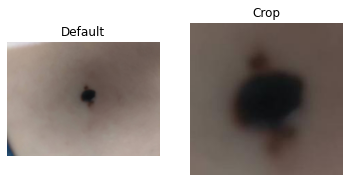

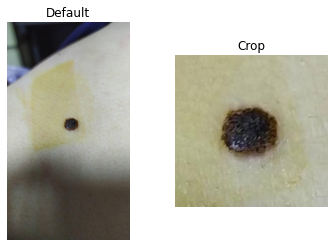

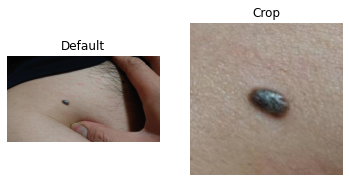

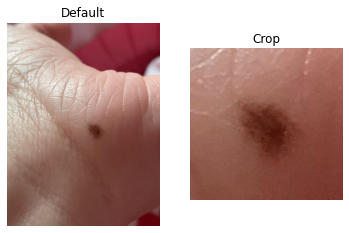

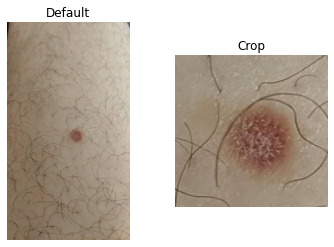

In [29]:
for i in range(5):

    sample(table_label, i, 'jpg/')
    pass

---

醫師標記過程，會有不同醫師標記同一筆資料的情況，針對這塊採取投票制。但是投票結果如果仍然有歧見，標記為「unknown」。

In [ ]:
item = table.loc[table['image_name']==i]

In [ ]:
item['prediction'].value_counts()

In [ ]:
def filter(table, doctor):
    table = table.loc[[i in doctor for i in table['dr']]]
    collection = []
    for d in doctor:
        selection = table.loc[(table['dr']==d)]
        if(selection.shape[0]==0):
            continue
        group = []
        for i in set(selection['image_name']):
            item = selection.loc[selection['image_name']==i]
            item = item.iloc[-1:,:]
            # # print(item['image_name'].item())
            # if(item['prediction'].isna().item() or item['prediction'].item()==""):  ##  忽略`prediction`有空值的資料
            #     print("row_id {}的`prediction`有空值的資料".format(item['rowid'].item()))
            #     print("標記結果{}，標記醫師{}".format(item['result'].item(), item['dr'].item()))
            #     continue
            item = item[['dataset' ,'user_id', 'image_name','prediction','create_time', 'result', 'dr', 'score']].copy()
            group += [item]
            pass
        group = pandas.concat(group)
        collection += [group]
        pass
    collection = pandas.concat(collection).reset_index(drop=True)
    image = []
    for _, item in collection.iterrows():
        if('crop' not in item['image_name']):
            # print(item['image_name'])
            # print(str(item['image_name']).split(".jpg")[0] + "_crop.jpg")
            image += [str(item['image_name']).split(".jpg")[0] + "_crop.jpg"]
            pass
        else:
            image += [item['image_name']]
        pass
    # print(image)
    collection.drop(columns='image_name')
    collection['image_name'] = image
    output = collection
    return(output)

In [ ]:
table = filter(table=table, doctor=['christine', "leon", 'dave', 'jack', 'eric'])

##  可以統計醫師標記的數量。

In [ ]:
# table.groupby()
table['month'] = [str(i).split(" ")[0][:-3] for i in table['create_time']]
table.groupby(['month', 'dr', 'result']).count()
#pandas.crosstab(table['month'], table['result'], table['dr']).to_csv("Doe-9月底數量.csv")

##  有發現一些資料的 prediction 值為空，會需要過濾掉。

In [ ]:
table = table.loc[table['prediction']!=""].copy()

In [ ]:
print(table.shape[0])
table.head()

##  每個資料可能被一位或者多位醫師標記，以下針對各種情況分別處理：
- 如果該資料只被一位醫師標記，其結果即代表真實標記
- 如果該資料被兩位醫師標記，檢查是否一致，否則標記為「不知道」
- 如果該資料被三位醫師標記，採用投票制。如果最多票為一票，代表三位醫師標記階不相同，標記為「不知道」。
- （未加入）如果該資料被四位醫師標記，採用投票制。如果最多票為一票，代表四位醫師標記階不相同，標記為「不知道」；如果最多票跟最少票數量一樣皆為兩票，代表四位醫師中同時發生兩位醫師標記一致，標記為「不知道」。

In [ ]:
table = table
group = []
for i in set(table['image_name']):  ##  根據圖片的名稱逐一挑選
    item = table.loc[table['image_name']==i]
    if(item.shape[0]==1):  ##  一位醫師標記
        case = item.copy()           
        case['vote_label'] = case['result']
        group += [case]
        pass
    if(item.shape[0]==2):  ##  兩位醫師標記
        case = item.copy()                          
        result = case['result'].unique().tolist()
        if(len(result)==1):  ##  兩位醫師標記一樣
            case['vote_label'] = result[0]
            case = case.iloc[-1:,:].copy()
            group += [case]
            pass
        else:  ##  兩位醫師標記不一樣
            case['vote_label'] = "unknown"
            case = case.iloc[-1:,:].copy()
            group += [case]
            pass
        pass
    if(item.shape[0]==3):  ##  三位醫師標記
        case = item.copy()
        result, ticket = Counter(case['result']).most_common()[0]  ##  挑出最多票的結果以及票數
        if(ticket>1):  ##  最多票大於 1 則代表有兩位醫師標記一樣
            case['vote_label'] = result
            case = case.iloc[-1:,:].copy()
            group += [case]
        else:  ##  最多票等於 1 代表三位醫師結果不同
            case['vote_label'] = "unknown"
            case = case.iloc[-1:,:].copy()
            group += [case]
        pass
    if(item.shape[0]==4):
        case = item.copy()
        result, ticket = Counter(case['result']).most_common()[0]
        if(ticket==4):  ##  最多票是 4 則代表四位醫師標記一樣
            case['vote_label'] = result
            case = case.iloc[-1:,:].copy()
            group += [case]
        else:
            ##  處理四位醫師標記的其他可能。
            print("請寫code處理四位醫師標記不一致的其他可能，當你看到這個訊息代表你被前面的人/自己挖坑了。")
        pass
    pass

group = pandas.concat(group).reset_index(drop=True)
group.shape

檢查`group`表中的圖片欄位的值是否有重複，有重複代表上面腳本有錯。

In [ ]:
check = len(group['image_name'].unique()) == len(group)
check

In [ ]:
print(group.shape)
group.head()

In [ ]:
risk = group.loc[(group['vote_label']=='lower')|(group['vote_label']=='higher')]
prediction = risk['prediction'].replace({"Lower":"lower", "Higher":"higher"}).copy()
risk = risk.drop(columns=['prediction'])
risk['prediction'] = prediction
print(risk.shape)
risk.head()

標記的結果彙整

In [ ]:
risk['vote_label'].value_counts()

In [ ]:
risk['dataset'].value_counts()

In [ ]:
##  字串統一轉成小寫
vote = risk['vote_label'].str.lower().tolist().copy()
prediction = risk['prediction'].str.lower().tolist().copy()
risk = risk.drop(columns=['prediction', 'vote_label']).copy()
risk['prediction'] = prediction
risk['vote_label'] = vote

##  與模型結果的比較

In [ ]:
matrix = metrics.confusion_matrix(
    y_true=risk['vote_label'],
    y_pred=risk['prediction'],
    labels=['higher', "lower"]
)
print("confusion matrix with true(row) and prediction(column)")
matrix

##  AUC

In [ ]:
roc_auc = sklearn.metrics.roc_auc_score(y_score=risk['score'], y_true=risk['vote_label'].replace({"lower":0, "higher":1}))
roc_auc

In [ ]:
fpr, tpr, threshold = sklearn.metrics.roc_curve(y_score=[float(i) for i in risk['score']], y_true = [float(i) for i in risk['vote_label'].replace({"lower":0, "higher":1})])
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
pandas.DataFrame({"FPR":fpr, "TPR":tpr, "Threshold":threshold}).to_csv("cache.csv", index=False)

In [ ]:
accuracy = matrix.diagonal().sum() / matrix.sum()
print("accuracy")
accuracy

In [ ]:
print("tpr")
matrix[0,0] / matrix[0,:].sum()

In [ ]:
print("tnr")
matrix[1,1] / matrix[1,:].sum()

In [ ]:
print("ppv")
matrix[0,0] / matrix[:,0].sum()

In [ ]:
print("npv")
matrix[1,1] / matrix[:,1].sum()

In [ ]:
##  The client of database.
connection = pymysql.connect(
    host='dermai.clhzpxphx83l.ap-northeast-1.rds.amazonaws.com',
    user='admin',
    password='dermai_root_1234',
    database='ai_tools'
)
query = "SELECT * FROM `moleme`;"
table = pandas.read_sql(query, connection)[['user_id', 'timestamp', 'image', 'image_crop', 'mole_size', "period", "change", "gender", "age"]]
table['mole_size'] = table['mole_size'].replace({"0":"有","1":"沒有"})
table['change'] = table['change'].replace({"0":"有","1":"沒有","2":"不確定"})
table['gender'] = table['gender'].replace({"0":"男性", "1":"女性","2":"不想回答"})
table['age'] = table['age'].replace({"0":"21歲以下","1":"21~40歲", "2":"41~65歲", "3":"65歲以上"})
table['period'] = table['period'].replace({"0":"一個月內",'1':"1個月~1年", "2":"一年以上","3":"不記得"})
table_askin = table
print(table_askin.shape)
table_askin.head()

In [ ]:
##  The client of database.
connection = pymysql.connect(
    host='dermai.clhzpxphx83l.ap-northeast-1.rds.amazonaws.com',
    user='admin',
    password='dermai_root_1234',
    database='molecheck'
)
query = "SELECT * FROM `new_moledata`;"
table = pandas.read_sql(query, connection)[['user_id', 'timestamp', 'image', 'image_crop', 'mole_size', "period", "change", "gender", "age"]]
table_oa = table
print(table_oa.shape)
table_oa.head()

In [ ]:
mole_size = []
period = []
change = []
gender = []
age = []
for index, i in enumerate(risk['image_name']):
    # i = risk['image_name'][0]
    item = table_oa.loc[table['image_crop']==i]
    if(item.shape[0]==1):
        mole_size += [item['mole_size'].item()]
        period += [item['period'].item()]
        change += [item['change'].item()]
        gender += [item['gender'].item()]
        age += [item['age'].item()]
        pass
    else:
        item = table_askin.loc[table['image_crop']==i]
        if(item.shape[0]==1):
            mole_size += [item['mole_size'].item()]
            period += [item['period'].item()]
            change += [item['change'].item()]
            gender += [item['gender'].item()]
            age += [item['age'].item()]
            pass        
        else:
            print(i)
            print(item)
            print("找不到資料或找到多筆")
            break
            pass
        pass
    pass

In [ ]:
len(mole_size)

In [ ]:
risk.head()

##  暫存步驟，上述有兩張表相對重要，`group`表存放了醫師標記的所有結果，`risk`表存放了醫師標記高風險以及低風險的表。

In [ ]:
group.to_csv("moleme-group.csv", index=False)
risk.to_csv("moleme-risk.csv", index=False)

##  後續微調模型會需要輸入使用者的問題，根據圖片去進行資料彙整，用戶變數來源有兩張表（ASKiN以及OA），但是表的結構不同，需要分別整理，再統一。

OA表擷取

In [ ]:
##  The client of database.
connection = pymysql.connect(
    host='dermai.clhzpxphx83l.ap-northeast-1.rds.amazonaws.com',
    user='admin',
    password='dermai_root_1234',
    database='molecheck'
)
query = "SELECT * FROM `new_moledata`;"
table = pandas.read_sql(query, connection)[['user_id', 'timestamp', 'image', 'image_crop', 'mole_size', "period", "change", "gender", "age"]]

In [ ]:
risk = pandas.read_csv("moleme-risk.csv")
group = []
for iteration, item in risk.iterrows():
    choose = table.loc[table['image_crop']==item['image_name']].copy()
    if(choose.shape[0]==1):
        choose['vote_label'] = item['vote_label']
        choose['dataset'] = item['dataset']
        choose['prediction'] = item['prediction']
        choose['score'] = item['score']
        group += [choose]
    elif(choose.shape[0]==0):
        continue
    else:
        choose = choose.iloc[-1:,:].copy()
        choose['vote_label'] = item['vote_label']
        choose['dataset'] = item['dataset']
        choose['prediction'] = item['prediction']
        choose['score'] = item['score']
        group += [choose]
    pass
group = pandas.concat(group)
oa = group.copy()
print(oa.shape[0])
oa.head()

ASKiN表擷取

In [ ]:
##  The client of database.
connection = pymysql.connect(
    host='dermai.clhzpxphx83l.ap-northeast-1.rds.amazonaws.com',
    user='admin',
    password='dermai_root_1234',
    database='ai_tools'
)
query = "SELECT * FROM `moleme`;"
table = pandas.read_sql(query, connection)[['user_id', 'timestamp', 'image', 'image_crop', 'mole_size', "period", "change", "gender", "age"]]
table['mole_size'] = table['mole_size'].replace({"0":"有","1":"沒有"})
table['change'] = table['change'].replace({"0":"有","1":"沒有","2":"不確定"})
table['gender'] = table['gender'].replace({"0":"男性", "1":"女性","2":"不想回答"})
table['age'] = table['age'].replace({"0":"21歲以下","1":"21~40歲", "2":"41~65歲", "3":"65歲以上"})
table['period'] = table['period'].replace({"0":"一個月內",'1':"1個月~1年", "2":"一年以上","3":"不記得"})
print(table.shape[0])
table.head()

In [ ]:
risk = pandas.read_csv("moleme-risk.csv")
group = []
for iteration, item in risk.iterrows():
    if(item['dataset']=='MoleMe'):
        choose = table.loc[table['image_crop']==item['image_name']].copy()
        if(choose.shape[0]==1):
            choose['vote_label'] = item['vote_label']
            choose['dataset'] = item['dataset']
            choose['prediction'] = item['prediction']
            choose['score'] = item['score']
            group += [choose]
        elif(choose.shape[0]==0):
            # print(item['dataset'])
            continue
        else:
            choose = choose.iloc[-1:,:].copy()
            choose['vote_label'] = item['vote_label']
            choose['dataset'] = item['dataset']
            choose['prediction'] = item['prediction']
            choose['score'] = item['score']
            group += [choose]
        pass
    pass
group = pandas.concat(group)
askin = group
print(askin.shape[0])
askin.head()

##  總和必須跟先前一致，否則代表中間有錯誤，需要回頭檢視問題。

In [ ]:
askin.shape[0] + oa.shape[0]

In [ ]:
table = pandas.concat([askin, oa])
table.head()

##  表中的用戶問題特徵，OA跟ASKiN兩表中的值不一致，統一整理。

In [ ]:
table['mole_size'] = table['mole_size'].replace({"有":"yes", "沒有":"no"})
set(table['mole_size'])

In [ ]:
table['age'] = table['age'].replace({"40~65歲":"41~65歲"})
set(table['age'])

In [ ]:
table['period'] = table['period'].replace({"1個月內":"一個月內", "1個月～1年":"1個月~1年","1年以上":"一年以上"})
set(table['period'])

In [ ]:
table['change'] = table['change'].replace({"不確定":"不記得","有變化":"有", "無變化":"沒有"})
set(table['change'])

In [ ]:
set(table['gender'])

In [ ]:
set(table['prediction'])

In [ ]:
set(table['vote_label'])

##  暫存步驟，上述產生的表相對重要，其中彙整了來自OA以及ASKiN的用戶回答特徵，並且針對問題特徵中同義但不同值的部份進行了統一，存成檔名為`data.csv`。

In [ ]:
table.to_csv("data.csv", index=False)

##  根據整理好的表來下載圖片（連結之後會更動），會需要些時間。
- moleme_media_url = "https://reservation.dermai.com.tw/static/media/data/mole/"
- moleme_oa_media_url = "https://oldmoleme.dermai.com.tw/static/data/"

In [ ]:
import requests, pandas
from PIL import Image
from io import BytesIO
import tqdm
import os 

In [ ]:
import requests, pandas
from PIL import Image
from io import BytesIO
import tqdm
import os 
table = pandas.read_csv('data.csv')
url = ["https://reservation.dermai.com.tw/static/media/data/mole/", "https://oldmoleme.dermai.com.tw/static/data/"]
for iteration, item in tqdm.tqdm(table.iterrows(), total=len(table)):
    try:
        source = requests.get(url[0]+item['image_crop'])
        image = Image.open(BytesIO(source.content))
    except:
        source = requests.get(url[1]+item['image_crop'])
        image = Image.open(BytesIO(source.content))
    pass
    os.makedirs(item['vote_label'], exist_ok=True)
    image.save(os.path.join(item['vote_label'], item['image_crop']))
    pass

##  總結，該腳本負責產出MoleMe訓練及測試所使用的資料集，包含`data(CSV檔)`以及`lower & higher(圖片資料夾)`，其餘都不重要。